In [13]:
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2


In [14]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name)) 

GPU device not found
Found GPU at: 


In [15]:
original_dirs = {
    'Calculus': './Calculus/Calculus',
    'Caries': './Data caries/Data caries/caries augmented data set/preview',
    'Gingivitis': './Gingivitis/Gingivitis',
    'Ulcers': './Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview',
    'Tooth Discoloration': './Tooth Discoloration/Tooth Discoloration/tooth discoloration original dataset/tooth discoloration original dataset',
    'Hypodontia': './hypodontia/hypodontia'
}

# Define the target base directory
base_dir = './dataset'
splits = ['train', 'val', 'test']
classes = list(original_dirs.keys())
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Initialize dictionaries to hold the counts for train, val, and test sets
class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}

# Function to copy images to the target directory and count them
def copy_and_count_images(class_name, image_paths):
    # Split the data
    train_paths, test_paths = train_test_split(image_paths, test_size=0.1, random_state=42)
    train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 0.2 * 0.9 = 0.18

    # Define split mappings
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Copy images to their respective directories and count them
    for split, paths in split_paths.items():
        class_split_counts[class_name][split] = len(paths)
        for img_path in paths:
            target_path = os.path.join(base_dir, split, class_name, os.path.basename(img_path))
            shutil.copy(img_path, target_path)

# Traverse the original directories and gather image paths
for class_name, original_dir in original_dirs.items():
    image_paths = []
    for root, dirs, files in os.walk(original_dir):
        image_paths.extend([os.path.join(root, file) for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.gif'))])
    if image_paths:
        copy_and_count_images(class_name, image_paths)

print("Images have been copied and organized successfully.")


Images have been copied and organized successfully.


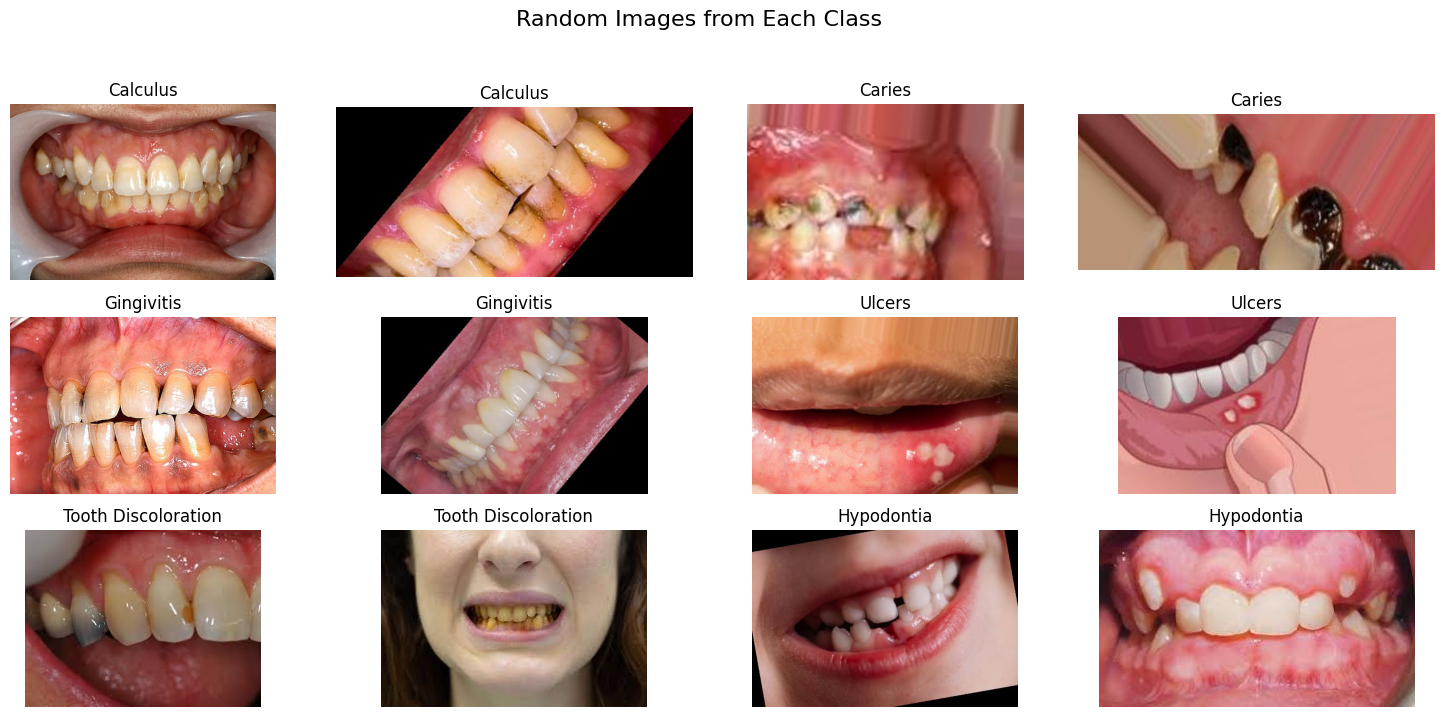

In [16]:

num_images_per_class = 2
num_images_per_row = 4
random.seed(42)
def get_random_images_from_dir(directory, num_images):
    all_images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg', '.jpeg', '.png'))]
    if len(all_images) < num_images:
        return all_images
    return random.sample(all_images, num_images)
num_rows = (len(classes) * num_images_per_class + num_images_per_row - 1) // num_images_per_row  # Calculate number of rows needed
fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows * 2.5))
fig.suptitle('Random Images from Each Class', fontsize=16)
axs = axs.flatten()
image_idx = 0
for class_name in classes:
    class_dir = os.path.join(base_dir, 'train', class_name)
    random_images = get_random_images_from_dir(class_dir, num_images_per_class)

    for img_path in random_images:
        if image_idx < len(axs):
            img = Image.open(img_path)
            if img.mode != 'RGBA':
                img = img.convert('RGBA')
            ax = axs[image_idx]
            ax.imshow(img)
            ax.set_title(class_name)
            ax.axis('off')
            image_idx += 1

for i in range(image_idx, len(axs)):
    axs[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
print(classes)

['Calculus', 'Caries', 'Gingivitis', 'Ulcers', 'Tooth Discoloration', 'Hypodontia']


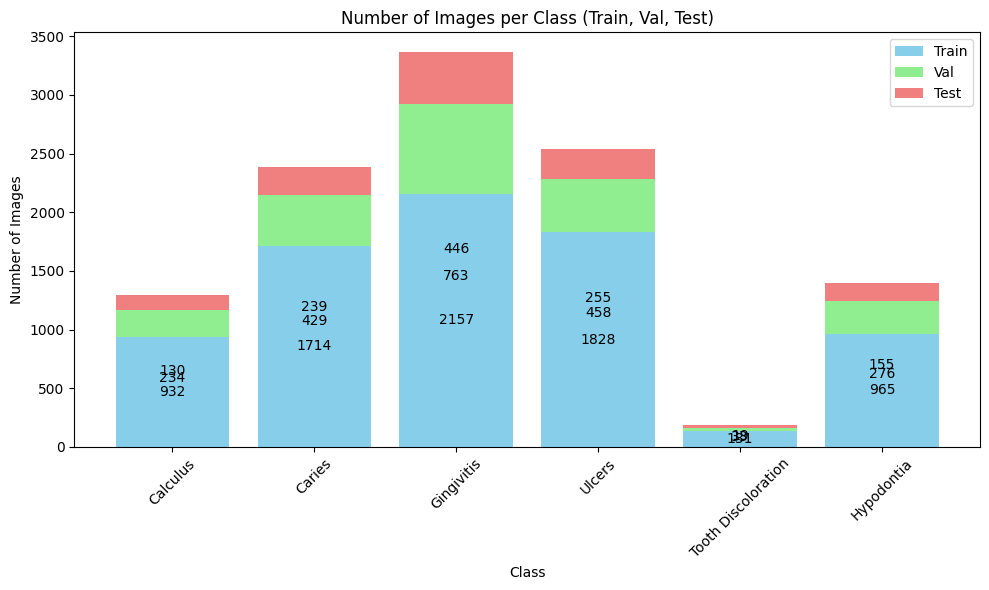

In [17]:

class_split_counts = {class_name: {'train': 0, 'val': 0, 'test': 0} for class_name in classes}
def count_images(base_dir, class_name):
    counts = {}
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split, class_name)
        counts[split] = len(os.listdir(split_dir))
    return counts
for class_name in classes:
    class_split_counts[class_name] = count_images(base_dir, class_name)
labels = classes
train_counts = [class_split_counts[class_name]['train'] for class_name in classes]
val_counts = [class_split_counts[class_name]['val'] for class_name in classes]
test_counts = [class_split_counts[class_name]['test'] for class_name in classes]

x = range(len(classes))
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(x, train_counts, label='Train', color='skyblue')
bar2 = ax.bar(x, val_counts, bottom=train_counts, label='Val', color='lightgreen')
bar3 = ax.bar(x, test_counts, bottom=[i+j for i,j in zip(train_counts, val_counts)], label='Test', color='lightcoral')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class (Train, Val, Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(yval), ha='center', va='center', color='black')

for bar in bar2:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

for bar in bar3:
    yval = bar.get_height() + bar.get_y()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, int(bar.get_height()), ha='center', va='center', color='black')

plt.tight_layout()
plt.show()


In [18]:
import os

print("Train classes:", len(os.listdir(train_dir)))
print("Validation classes:", len(os.listdir(val_dir)))


Train classes: 6
Validation classes: 6


In [19]:
 
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

trainGenerator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input 
).flow_from_directory(train_dir, target_size=(300, 300), batch_size=32)

valGenerator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input 
).flow_from_directory(val_dir, target_size=(300, 300), batch_size=32)

# Bangun model dalam scope strategi
with tf.device('/GPU:0'):
    baseModel = MobileNetV3Small(weights="imagenet", include_top=False) 
    
    # Setup data augmentation 
    x = baseModel.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    predictionLayer = Dense(6, activation="softmax")(x)

    model = Model(inputs=baseModel.input, outputs=predictionLayer)
    for layer in model.layers[:-20]:
      layer.trainable = True

    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    
    # Training
    history = model.fit(
        trainGenerator,
        validation_data=valGenerator,
        epochs=10,
        callbacks=[lr_scheduler, early_stopping]
    )
    
    # Fine-tuning
    model.compile(
        loss="binary_crossentropy",  # Tetap gunakan binary_crossentropy jika ini multi-label
        optimizer=Adam(learning_rate=1e-5),
        metrics=['accuracy']
    )
    
    history_finetune = model.fit(
        trainGenerator,
        validation_data=valGenerator,
        epochs=10,
        callbacks=[lr_scheduler, early_stopping]
    )

# Callbacks


Found 7727 images belonging to 6 classes.
Found 2193 images belonging to 6 classes.
Epoch 1/10
242/242 [==============================] - 621s 2s/step - loss: 6.6081 - accuracy: 0.6790 - precision_5: 0.7842 - recall_5: 0.5605 - auc_5: 0.9237 - val_loss: 4.4608 - val_accuracy: 0.8071 - val_precision_5: 0.8283 - val_recall_5: 0.7875 - val_auc_5: 0.9675 - lr: 1.0000e-04
Epoch 2/10
242/242 [==============================] - 591s 2s/step - loss: 3.1004 - accuracy: 0.8611 - precision_5: 0.8787 - recall_5: 0.8441 - auc_5: 0.9850 - val_loss: 2.0627 - val_accuracy: 0.8586 - val_precision_5: 0.8640 - val_recall_5: 0.8545 - val_auc_5: 0.9789 - lr: 1.0000e-04
Epoch 3/10
242/242 [==============================] - 588s 2s/step - loss: 1.4160 - accuracy: 0.8906 - precision_5: 0.9027 - recall_5: 0.8822 - auc_5: 0.9898 - val_loss: 0.9435 - val_accuracy: 0.8751 - val_precision_5: 0.8812 - val_recall_5: 0.8728 - val_auc_5: 0.9824 - lr: 1.0000e-04
Epoch 4/10
242/242 [==============================] - 590s

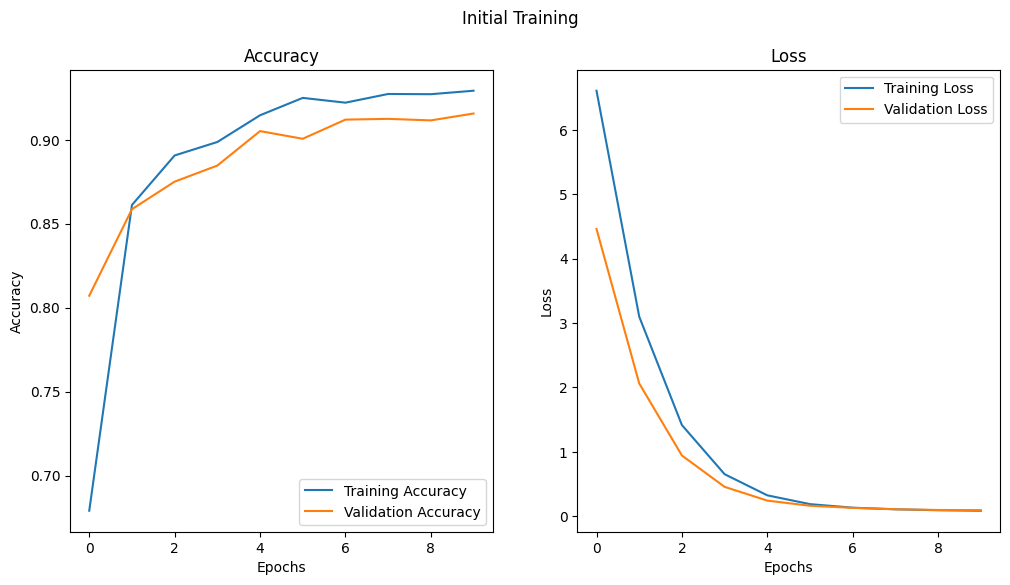

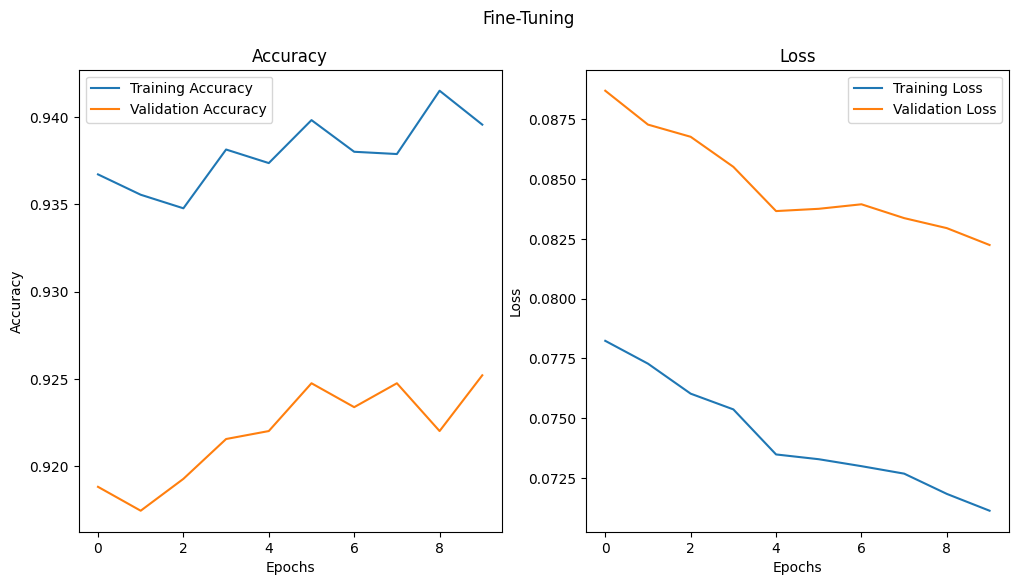

Model telah disimpan dalam file 'model_final.h2'.
Found 1244 images belonging to 6 classes.
39/39 [==============================] - 33s 847ms/step - loss: 0.0932 - accuracy: 0.9124
Testing Loss: 0.0932
Testing Accuracy: 0.9124
39/39 [==============================] - 27s 647ms/step
Image 1: True Class = 0, Predicted Class = 2
Image 2: True Class = 0, Predicted Class = 0
Image 3: True Class = 0, Predicted Class = 0
Image 4: True Class = 0, Predicted Class = 0
Image 5: True Class = 0, Predicted Class = 2
Image 6: True Class = 0, Predicted Class = 0
Image 7: True Class = 0, Predicted Class = 0
Image 8: True Class = 0, Predicted Class = 0
Image 9: True Class = 0, Predicted Class = 3
Image 10: True Class = 0, Predicted Class = 2


In [20]:
# Menampilkan grafik hasil pelatihan dan validasi
def plot_training_history(history, title="Model Training History"):
    plt.figure(figsize=(12, 6))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.show()

# Menampilkan grafik untuk training pertama
plot_training_history(history, title="Initial Training")

# Menampilkan grafik untuk fine-tuning
plot_training_history(history_finetune, title="Fine-Tuning")

# Menyimpan model ke dalam file HDF5
model.save('adam.keras')

print("Model telah disimpan dalam file 'model_final.h2'.")
testGenerator = ImageDataGenerator().flow_from_directory(
    test_dir, target_size=(320, 320), batch_size=32, shuffle=False
)

# Evaluasi model pada data testing
results = model.evaluate(testGenerator)
print(f"Testing Loss: {results[0]:.4f}")
print(f"Testing Accuracy: {results[1]:.4f}")

# Membuat prediksi pada data testing
predictions = model.predict(testGenerator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = testGenerator.classes

# Menampilkan beberapa hasil prediksi
for i in range(10):
    print(f"Image {i+1}: True Class = {true_classes[i]}, Predicted Class = {predicted_classes[i]}")


39/39 [==============================] - 26s 646ms/step


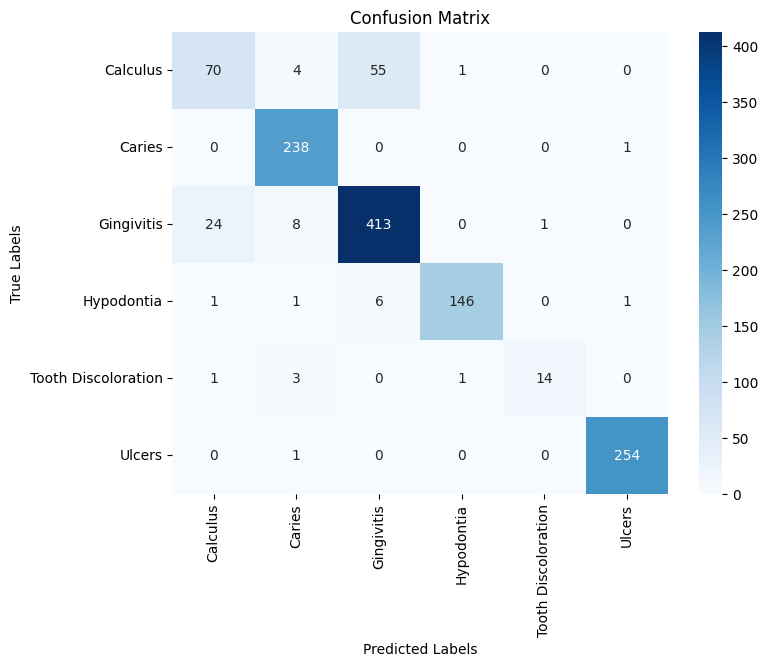

Classification Report:
                     precision    recall  f1-score   support

           Calculus      0.729     0.538     0.619       130
             Caries      0.933     0.996     0.964       239
         Gingivitis      0.871     0.926     0.898       446
         Hypodontia      0.986     0.942     0.964       155
Tooth Discoloration      0.933     0.737     0.824        19
             Ulcers      0.992     0.996     0.994       255

           accuracy                          0.912      1244
          macro avg      0.908     0.856     0.877      1244
       weighted avg      0.908     0.912     0.908      1244



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(testGenerator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = testGenerator.classes
class_labels = list(testGenerator.class_indices.keys())  # Mendapatkan label kelas
 
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show() 
class_labels = list(testGenerator.class_indices.keys()) 
# Menampilkan laporan klasifikasi
print("Classification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=3)
print(report)

**Adam 64**

In [36]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('adam.keras')
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r'C:\Users\Home\Downloads\caries classfication\dataset\test'  # Change to your image path
test_dir = os.path.join(base_dir, 'test')
testGenerator = ImageDataGenerator().flow_from_directory(
    test_dir, target_size=(320, 320), batch_size=32, shuffle=False
)
predictions = model.predict(testGenerator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = testGenerator.classes

# Menampilkan beberapa hasil prediksi
for i in range(len(predicted_classes)):
    print(f"Image {i+1}: True Class = {true_classes[i]}, Predicted Class = {predicted_classes[i]}")



Found 1244 images belonging to 6 classes.
39/39 [==============================] - 23s 560ms/step
Image 1: True Class = 0, Predicted Class = 2
Image 2: True Class = 0, Predicted Class = 0
Image 3: True Class = 0, Predicted Class = 0
Image 4: True Class = 0, Predicted Class = 0
Image 5: True Class = 0, Predicted Class = 2
Image 6: True Class = 0, Predicted Class = 0
Image 7: True Class = 0, Predicted Class = 0
Image 8: True Class = 0, Predicted Class = 0
Image 9: True Class = 0, Predicted Class = 3
Image 10: True Class = 0, Predicted Class = 2
Image 11: True Class = 0, Predicted Class = 0
Image 12: True Class = 0, Predicted Class = 0
Image 13: True Class = 0, Predicted Class = 2
Image 14: True Class = 0, Predicted Class = 2
Image 15: True Class = 0, Predicted Class = 2
Image 16: True Class = 0, Predicted Class = 0
Image 17: True Class = 0, Predicted Class = 0
Image 18: True Class = 0, Predicted Class = 0
Image 19: True Class = 0, Predicted Class = 0
Image 20: True Class = 0, Predicted C

In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Load the trained model
model = tf.keras.models.load_model('adam.keras')

# Define the test directory
base_dir = r'C:\Users\Home\Downloads\caries classfication\dataset'
test_dir = os.path.join(base_dir, 'test')

# Initialize ImageDataGenerator
testGenerator = ImageDataGenerator().flow_from_directory(
    test_dir, target_size=(320, 320), batch_size=32, shuffle=False
)

# Get predictions
predictions = model.predict(testGenerator)

# Get predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = testGenerator.classes

# Calculate the number of correct predictions
correct_predictions = np.sum(predicted_classes == true_classes)

# Calculate total number of predictions
total_predictions = len(true_classes)

# Calculate accuracy
accuracy = correct_predictions / total_predictions * 100

# Print results
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy: {accuracy:.2f}%")

# Optionally, display the results for each image
for i in range(len(predicted_classes)):
    print(f"Image {i+1}: True Class = {true_classes[i]}, Predicted Class = {predicted_classes[i]}")


Found 1244 images belonging to 6 classes.
39/39 [==============================] - 23s 566ms/step
Correct Predictions: 1135/1244
Accuracy: 91.24%
Image 1: True Class = 0, Predicted Class = 2
Image 2: True Class = 0, Predicted Class = 0
Image 3: True Class = 0, Predicted Class = 0
Image 4: True Class = 0, Predicted Class = 0
Image 5: True Class = 0, Predicted Class = 2
Image 6: True Class = 0, Predicted Class = 0
Image 7: True Class = 0, Predicted Class = 0
Image 8: True Class = 0, Predicted Class = 0
Image 9: True Class = 0, Predicted Class = 3
Image 10: True Class = 0, Predicted Class = 2
Image 11: True Class = 0, Predicted Class = 0
Image 12: True Class = 0, Predicted Class = 0
Image 13: True Class = 0, Predicted Class = 2
Image 14: True Class = 0, Predicted Class = 2
Image 15: True Class = 0, Predicted Class = 2
Image 16: True Class = 0, Predicted Class = 0
Image 17: True Class = 0, Predicted Class = 0
Image 18: True Class = 0, Predicted Class = 0
Image 19: True Class = 0, Predicted

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the trained model
model = tf.keras.models.load_model('adam.keras')

# Load and preprocess a single image
img_path = r'C:\Users\SASIDHARAN.N\OneDrive\Desktop\caries classfication\check'  # Replace with actual image name
testGenerator = ImageDataGenerator().flow_from_directory(
    img_path, target_size=(320, 320), batch_size=32, shuffle=False
)


# Get predictions
predictions = model.predict(testGenerator)

# Get predicted class labels
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 1s 1s/step
[2]
